# Brain tumor detection using a CNN - Predict

In [117]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

Run this cell only if you are working on **Google Collab**

In [ ]:
import urllib
import zipfile

# Download and unzip the dataset
if not os.path.isfile('Brain Tumor Data Set.zip'):
  urllib.request.urlretrieve("https://github.com/TomMenga/brain-tumor-AI-CNN/blob/main/Brain%20Tumor%20Data%20Set.zip?raw=true", "Brain Tumor Data Set.zip")

with zipfile.ZipFile("Brain Tumor Data Set.zip","r") as zip_ref:
    zip_ref.extractall(".")

# Download and unzip the pre-trained model
if not os.path.isfile('model_export.zip'):
  urllib.request.urlretrieve("https://github.com/TomMenga/brain-tumor-AI-CNN/blob/main/model_export.zip?raw=true", "model_export.zip")

with zipfile.ZipFile("model_export.zip","r") as zip_ref:
    zip_ref.extractall(".")

# Delete the zip files
os.remove('Brain Tumor Data Set.zip')
os.remove('model_export.zip')

### Parameters

In [3]:
test_dataset_path = './Brain Tumor Data Set/Test'

weights_export_path = './model_export/weights_only/brain_tumor_CNN'
model_export_path = './model_export/whole_model/'

batch_size = 32
img_height = 128
img_width = 128

seed = 42
random.seed(seed)

## Let's load our test set

In [78]:
# Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=32,
  shuffle=False)

Found 253 files belonging to 2 classes.


In [79]:
# The class names derive from the folder structure
class_names = test_ds.class_names
print(class_names)

['Cancer', 'Not cancer']


## Let's load the model

### Option 1 - Just load the weights
In order to load the weights we need to recreate the exact model architecture used in the training process

In [6]:
# Recreate the model architecture
model = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Conv2D(8, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(16, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(rate=0.3),
  Dense(64, activation='relu'),
  Dropout(rate=0.3),
  Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [7]:
# Restore the weights
model.load_weights(weights_export_path)

### Option 2 - Load the whole model

In [11]:
model = tf.keras.models.load_model(model_export_path)

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

## Let's evaluate our model

In [60]:
eval_out = model.evaluate(test_ds,
                          verbose=1)

print('Accuracy: {} \nLoss: {}'.format(round(eval_out[1], 2), round(eval_out[0], 2)))

1/1 [==============================] - 1s 624ms/step - loss: 0.0339 - accuracy: 0.9842
Accuracy: 0.98 
Loss: 0.03


## Let's calcutate the confusion matrix

In [173]:
# Let's predict our test cases
predictions = model.predict(test_ds).flatten()
predictions = np.array([round(p) for p in predictions]) # Round the prediction values

# Let's extract the actual images and labels from the tensors
labels = np.empty(0, 'int')
images = np.empty((0,128,128,3))

for batch_images, batch_labels in test_ds:
  for img in batch_images:
    images = np.append(images, [tf.get_static_value(img)], 0)
  for l in batch_labels:
    labels = np.append(labels, tf.get_static_value(l))


8/8 [==============================] - 1s 70ms/step


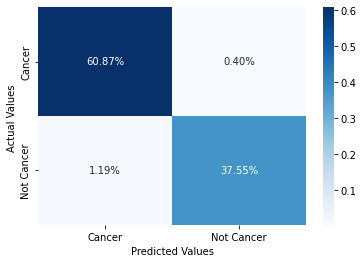

In [176]:
cf_matrix = tf.math.confusion_matrix(labels, predictions).numpy()

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Cancer','Not Cancer'])
ax.yaxis.set_ticklabels(['Cancer','Not Cancer'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Let's try our model

1/1 [==============================] - 0s 23ms/step


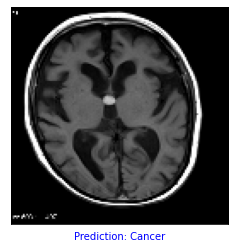

In [175]:
# Pick a random image
index_to_test = random.randrange(len(images))

test_image = images[index_to_test]
test_image_class = labels[index_to_test]

# Predict it
prediction = model.predict(np.expand_dims(test_image, 0))

# Visualize the prediction
predicted_value = round(prediction[0][0])
true_value = tf.get_static_value(test_image_class)
label_color = 'blue' if predicted_value == true_value else 'red'

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel("Prediction: {}".format(class_names[predicted_value]), color=label_color)
plt.imshow(test_image/255);